In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
import time

%matplotlib inline
plt.rcParams["figure.facecolor"] = "w"

## Data Loading

In [3]:
df = pd.read_csv('../data/processed/data_with_new_features.csv')
df.dropna(inplace=True)
df

,date,temperature,station_level_pressure,sea_level_pressure,humidity,dew_point,water_level,day_of_week,month,day_of_year,...,temperature_lag_3,humidity_lag_1,humidity_lag_2,humidity_lag_3,dew_point_lag_1,dew_point_lag_2,dew_point_lag_3,temperature_roll_mean_3,humidity_roll_mean_3,dew_point_roll_mean_3
7,2021-01-08,-23.8500,767.7500,787.550,80.750,-26.2500,155.0,4,1,8,...,-24.8500,75.000,71.250,67.500,-24.5750,-24.2500,-29.1750,-21.816667,75.666667,-25.025000
8,2021-01-09,-20.0500,761.5750,780.900,80.250,-22.7000,160.0,5,1,9,...,-20.3500,80.750,75.000,71.250,-26.2500,-24.5750,-24.2500,-21.716667,78.666667,-24.508333
9,2021-01-10,-11.4250,752.6000,771.100,76.250,-14.8500,160.0,6,1,10,...,-21.2500,80.250,80.750,75.000,-22.7000,-26.2500,-24.5750,-18.441667,79.083333,-21.266667
10,2021-01-11,-13.0000,745.3750,763.775,75.250,-16.5250,162.0,0,1,11,...,-23.8500,76.250,80.250,80.750,-14.8500,-22.7000,-26.2500,-14.825000,77.250000,-18.025000
11,2021-01-12,-21.7250,748.8250,767.975,76.000,-24.8750,160.0,1,1,12,...,-20.0500,75.250,76.250,80.250,-16.5250,-14.8500,-22.7000,-15.383333,75.833333,-18.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,2024-05-08,12.4625,745.4375,762.150,37.750,-3.1125,201.0,2,5,129,...,11.7250,41.125,65.000,74.250,-4.2000,5.5375,6.5375,12.004167,47.958333,-0.591667
1224,2024-05-09,12.2500,749.0375,765.875,34.375,-3.8375,200.0,3,5,130,...,12.8000,37.750,41.125,65.000,-3.1125,-4.2000,5.5375,11.820833,37.750000,-3.716667
1225,2024-05-10,13.9125,745.5750,762.225,35.875,-3.4125,197.0,4,5,131,...,10.7500,34.375,37.750,41.125,-3.8375,-3.1125,-4.2000,12.875000,36.000000,-3.454167
1226,2024-05-11,19.4625,740.2750,756.475,40.625,5.2000,196.0,5,5,132,...,12.4625,35.875,34.375,37.750,-3.4125,-3.8375,-3.1125,15.208333,36.958333,-0.683333


In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [5]:
features = [column for column in df.columns if column != 'water_level']
target = 'water_level'

In [8]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.1)
test_size = len(df) - train_size - val_size

df_train = df.iloc[:train_size][features + [target]]
df_val = df.iloc[train_size:train_size + val_size][features + [target]]
df_test = df.iloc[train_size + val_size:][features + [target]]

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)

Train shape: (854, 25)
Validation shape: (122, 25)
Test shape: (245, 25)


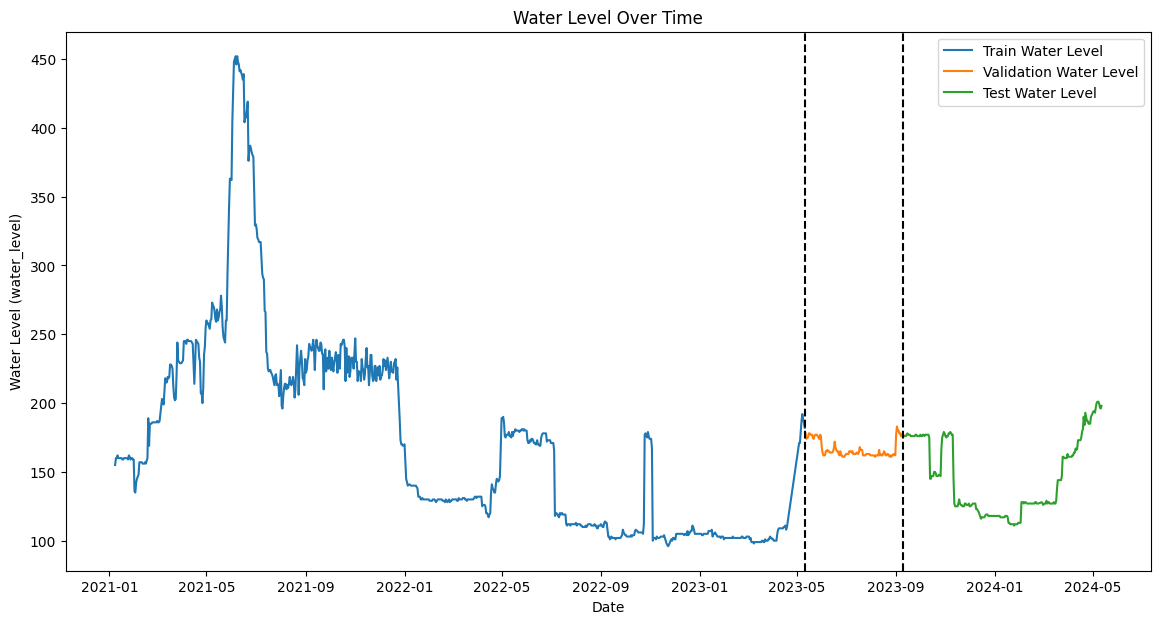

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(df_train.index, df_train['water_level'], label='Train Water Level')
plt.plot(df_val.index, df_val['water_level'], label='Validation Water Level')
plt.plot(df_test.index, df_test['water_level'], label='Test Water Level')
plt.axvline(df_train.index[-1], linestyle="--", c="black")
plt.axvline(df_val.index[-1], linestyle="--", c="black")
plt.legend()
plt.title("Water Level Over Time")
plt.xlabel("Date")
plt.ylabel("Water Level (water_level)")
plt.show()

## Data Scaling

In [10]:
scaler = StandardScaler()

train_features = scaler.fit_transform(df_train[features])

val_features = scaler.transform(df_val[features])
test_features = scaler.transform(df_test[features])

scaler_target = StandardScaler()
train_target = scaler_target.fit_transform(df_train[[target]])
val_target = scaler_target.transform(df_val[[target]])
test_target = scaler_target.transform(df_test[[target]])

train_arr = np.hstack([train_features, train_target])
val_arr = np.hstack([val_features, val_target])
test_arr = np.hstack([test_features, test_target])

print("Scaled train shape:", train_arr.shape)
print("Scaled validation shape:", val_arr.shape)
print("Scaled test shape:", test_arr.shape)

Scaled train shape: (854, 25)
Scaled validation shape: (122, 25)
Scaled test shape: (245, 25)


In [21]:
from joblib import dump, load

dump(scaler, '../saved_models/scaler.joblib')
dump(scaler_target, '../saved_models/scaler_target.joblib')

['../saved_models/scaler_target.joblib']

## Data Transfrom

In [12]:
def transform_data(arr, seq_len, n_features):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i:i + seq_len, :n_features]
        y_i = arr[i + 1:i + seq_len + 1, -1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len, n_features)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [13]:
seq_len = 10
n_features = len(features)

x_train, y_train = transform_data(train_arr, seq_len, n_features)
x_val, y_val = transform_data(val_arr, seq_len, n_features)
x_test, y_test = transform_data(test_arr, seq_len, n_features)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: torch.Size([844, 10, 24])
y_train shape: torch.Size([844, 10])
x_val shape: torch.Size([112, 10, 24])
y_val shape: torch.Size([112, 10])
x_test shape: torch.Size([235, 10, 24])
y_test shape: torch.Size([235, 10])


In [18]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title(f"{i+1}. Sequence")
    axes[i].set_xlabel("Time Steps")
    axes[i].set_ylabel("Scaled Feature")
    axes[i].plot(range(seq_len), x_train[i, :, -1].cpu().numpy(), color="r", label="Some Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

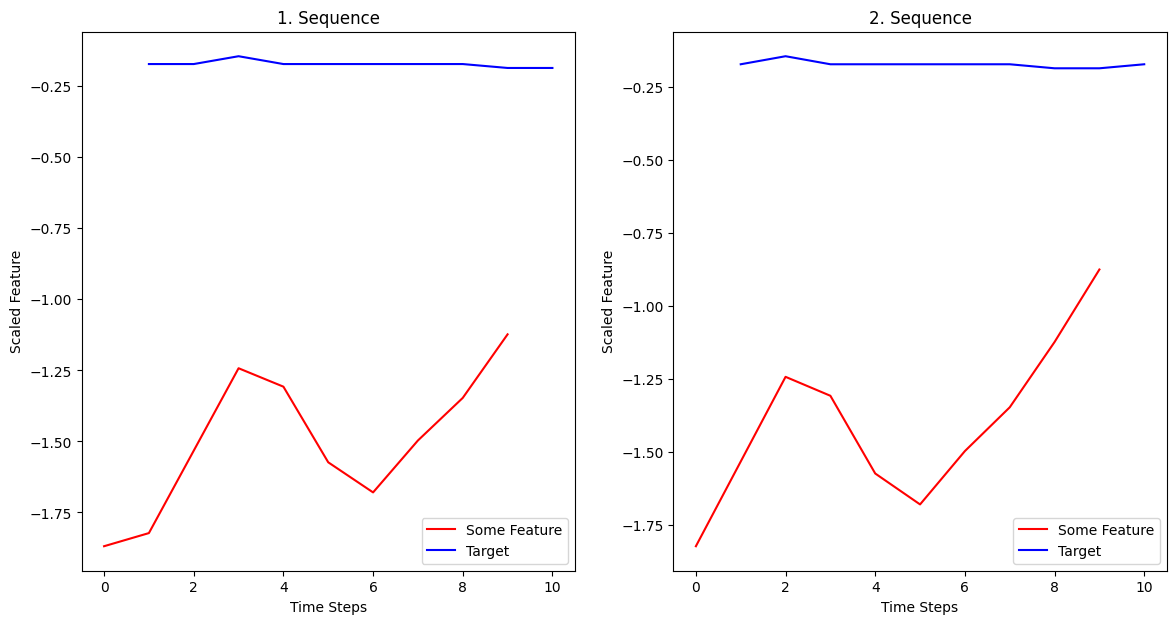

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)
plt.show()

# LSTM Model

In [17]:
import torch
import torch.nn as nn
import random

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size  # 6 признаков (T, Po, P, U, Td, wl)
        self.hidden_size = hidden_size
        self.output_size = output_size  # 1 выход (wl_next)
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []
        batch_size = input.size(0)

        h_t = torch.zeros(batch_size, self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(batch_size, self.hidden_size, dtype=torch.float32)

        for input_t in input.chunk(input.size(1), dim=1):
            input_t = input_t.squeeze(1)
            if input_t.dim() == 1:
                input_t = input_t.unsqueeze(0)
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs.append(output)

        for i in range(future):
            input_t = torch.zeros(batch_size, self.input_size, dtype=torch.float32)
            if y is not None and random.random() > 0.5:
                input_t[:, -1] = y[:, i]
            else:
                input_t[:, -1] = output.squeeze(1)
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs.append(output)

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

# Optimization

In [21]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for i in range(0, len(x), batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            yield x_batch, y_batch, i // batch_size

    def train(self, x_train, y_train, x_val=None, y_val=None, batch_size=32, n_epochs=15, do_teacher_forcing=False):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []
            train_loss = 0
            self.model.train()
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= (batch + 1)
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)
            elapsed = time.time() - start_time
            print(f"Epoch {epoch+1} Train loss: {train_loss:.4f}. Validation loss: {self.val_losses[-1]:.4f}. "
                  f"Avg future: {np.mean(self.futures):.2f}. Elapsed time: {elapsed:.2f}s.")

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len / 2))
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            y_pred = self.model(x_batch)
        self.futures.append(future if do_teacher_forcing else 0)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        self.model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= (batch + 1)
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        self.model.eval()
        test_loss = 0
        actual, predicted = [], []
        with torch.no_grad():
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = y_pred[:, :y_batch.shape[1]] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual.extend(torch.squeeze(y_batch[:, -1]).cpu().numpy().tolist())
                predicted.extend(torch.squeeze(y_pred[:, -1]).cpu().numpy().tolist())
            test_loss /= (batch + 1)
        return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Training and Validation Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

def generate_sequence(scaler, model, x_sample, future=30):
    model.eval()
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().numpy()
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred_tensor.shape)
    return y_pred

def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})

# Train

Epoch 1 Train loss: 1.0173. Validation loss: 0.4056. Avg future: 3.16. Elapsed time: 0.35s.
Epoch 2 Train loss: 0.9305. Validation loss: 0.3309. Avg future: 2.61. Elapsed time: 0.25s.
Epoch 3 Train loss: 0.8695. Validation loss: 0.2586. Avg future: 2.61. Elapsed time: 0.27s.
Epoch 4 Train loss: 0.7857. Validation loss: 0.1814. Avg future: 3.16. Elapsed time: 0.28s.
Epoch 5 Train loss: 0.6673. Validation loss: 0.1082. Avg future: 2.77. Elapsed time: 0.25s.
Epoch 6 Train loss: 0.5617. Validation loss: 0.1029. Avg future: 3.35. Elapsed time: 0.23s.
Epoch 7 Train loss: 0.5386. Validation loss: 0.0983. Avg future: 2.87. Elapsed time: 0.25s.
Epoch 8 Train loss: 0.5298. Validation loss: 0.0944. Avg future: 2.61. Elapsed time: 0.23s.
Epoch 9 Train loss: 0.5091. Validation loss: 0.0906. Avg future: 2.87. Elapsed time: 0.28s.
Epoch 10 Train loss: 0.5030. Validation loss: 0.0872. Avg future: 3.19. Elapsed time: 0.26s.
Epoch 11 Train loss: 0.4986. Validation loss: 0.0869. Avg future: 2.87. Elapsed

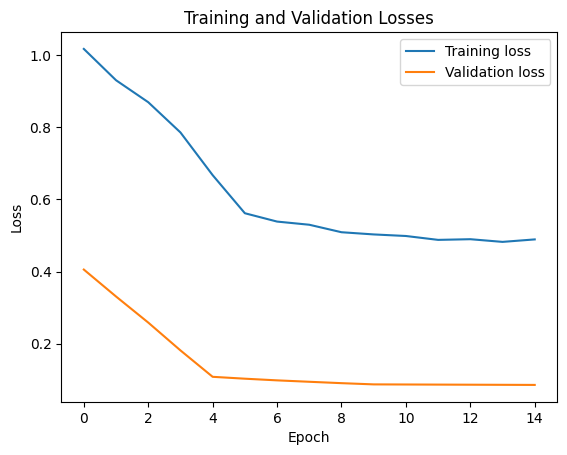

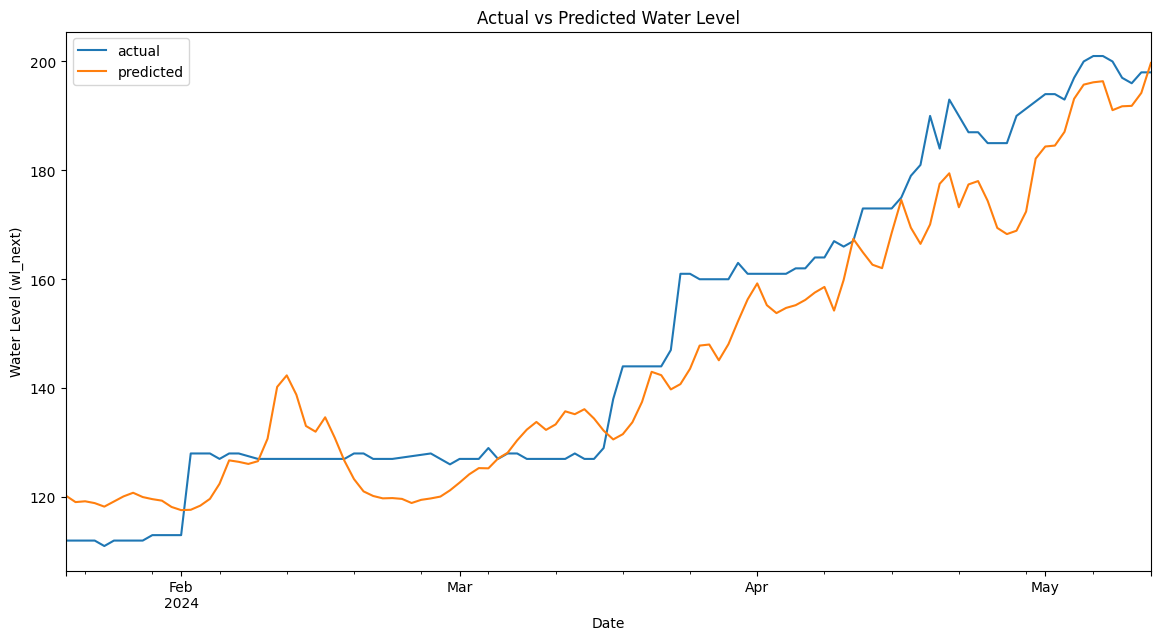

Test loss: 0.0583


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [22]:
model = Model(input_size=n_features, hidden_size=21, output_size=1)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimization = Optimization(model, loss_fn, optimizer, scheduler)

optimization.train(x_train, y_train, x_val, y_val, batch_size=32, n_epochs=15, do_teacher_forcing=True)

optimization.plot_losses()

actual, predicted, test_loss = optimization.evaluate(x_test, y_test, batch_size=32, future=1)
df_result = to_dataframe(actual, predicted)
df_result = pd.DataFrame(scaler_target.inverse_transform(df_result), columns=['actual', 'predicted'], index=df_test.index[seq_len:])

df_result.plot(figsize=(14, 7), title="Actual vs Predicted Water Level")
plt.xlabel("Date")
plt.ylabel("Water Level (wl_next)")
plt.show()
print(f"Test loss: {test_loss:.4f}")

x_sample = x_test[0:1]
y_pred = generate_sequence(scaler_target, model, x_sample, future=30)

plt.figure(figsize=(14, 7))
plt.plot(range(seq_len), y_pred[0, :seq_len], color="blue", label="Predicted WL")
plt.plot(range(seq_len, seq_len + 30), y_pred[0, seq_len:], "--", color="blue", label="Generated WL")
plt.plot(range(seq_len + 30), scaler_target.inverse_transform(y_test[:30].cpu().numpy().reshape(-1, 1)), color="red", label="Actual WL")
plt.legend()
plt.title("Predicted, Generated, and Actual Water Level")
plt.xlabel("Time Steps")
plt.ylabel("Water Level (wl_next)")
plt.show()